## Import Libraries

In [1]:

import os
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten
from keras.layers import Dense,Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import secrets
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Data Loading and Processing

Seeting the data path

In [2]:
# Define paths for dataset and model
base_path = "C:/Users/kimaa/OneDrive/Desktop"

data_path = os.path.join(base_path, "imgs", "train")
model_dir = os.path.join(base_path, "model", "vgg16_shallow_network")


print("Data Directory:", data_path)
print("Model Directory:", model_dir)

Data Directory: C:/Users/kimaa/OneDrive/Desktop\imgs\train
Model Directory: C:/Users/kimaa/OneDrive/Desktop\model\vgg16_shallow_network


### Data Pre-Processing Functions

In [3]:
# Preprocessing functions for the images
def enhance_brightness(img, value_increment):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_img)
    v = cv2.add(v, value_increment)
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

def change_contrast(img, level):
   img = Image.fromarray(img.astype('uint8'))
   factor = (259 * (level + 255)) / (255 * (259 - level))
   def contrast(c):
        return 128 + factor * (c - 128)
   return np.array(img.point(contrast))

def preprocess_img(img):
   img = np.array(img)
   x = secrets.randbelow(2)
   if x == 0:
        img = enhance_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
   else:
        img = change_contrast(img, secrets.randbelow(51))
        img = enhance_brightness(img, secrets.randbelow(26))
   return img


In [4]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.01,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode="nearest",
    validation_split=0.2,
    preprocessing_function=preprocess_img
)



In [5]:
train_data = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=128,
    subset='training',
    shuffle=True
)


Found 17943 images belonging to 10 classes.


In [6]:
test_data = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=128,
    subset='validation',
    shuffle=True
)

Found 4481 images belonging to 10 classes.


In [7]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam

def initialize_shallow_vgg16_model(input_shape, num_classes, learning_rate=1e-4):

    # Load VGG16 base model without the top layer and with pre-trained weights from ImageNet
    vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    # Mark the base model as non-trainable to preserve the features
    vgg_base.trainable = False

    # Initialize the model
    model = Sequential()
    model.add(vgg_base)  # Add the VGG16 base model

    # Flatten the output of the base model to a single dimension
    model.add(Flatten())

    # Add a simpler dense layer compared to the original code. Reduced the units to make the network shallower.
    model.add(Dense(256, activation='relu', kernel_initializer='glorot_normal'))  # Reduced from 500 to 256 units
    model.add(Dropout(0.5))  # Keep the dropout to avoid overfitting

    # Output layer
    model.add(Dense(num_classes, activation='softmax', kernel_initializer='glorot_normal'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [8]:
model = initialize_shallow_vgg16_model(input_shape=(224, 224, 3), num_classes=10)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Setup model checkpointing
checkpoint_path = os.path.join(model_dir, "model_vgg_shallow-{epoch:02d}-{val_accuracy:.2f}.keras")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [10]:
# Start training
history = model.fit(train_data,
                    epochs=20,
                    validation_data=test_data,
                    callbacks=[checkpoint_callback, early_stopping_callback])

# Save the model
try:
    model.save(os.path.join(model_dir, 'final_model_deep_net_batchwise.keras'))
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Epoch 1/20


C:\Users\kimaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2521 - loss: 9.9939 
Epoch 1: val_accuracy improved from -inf to 0.61370, saving model to C:/Users/kimaa/OneDrive/Desktop\model\vgg16_shallow_network\model_vgg_shallow-01-0.61.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 853s 6s/step - accuracy: 0.2525 - loss: 9.9533 - val_accuracy: 0.6137 - val_loss: 1.1781
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5013 - loss: 1.4677
Epoch 2: val_accuracy improved from 0.61370 to 0.85941, saving model to C:/Users/kimaa/OneDrive/Desktop\model\vgg16_shallow_network\model_vgg_shallow-02-0.86.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 848s 6s/step - accuracy: 0.5017 - loss: 1.4666 - val_accuracy: 0.8594 - val_loss: 0.4553
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6873 - loss: 0.9687
Epoch 3: val_accuracy improved from 0.85941 to 0.92479, saving model to C:/Users/kimaa/OneDrive/Desktop\model\vgg16_shallow_network\model_vgg_shallow-03-0.92.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 8

In [11]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

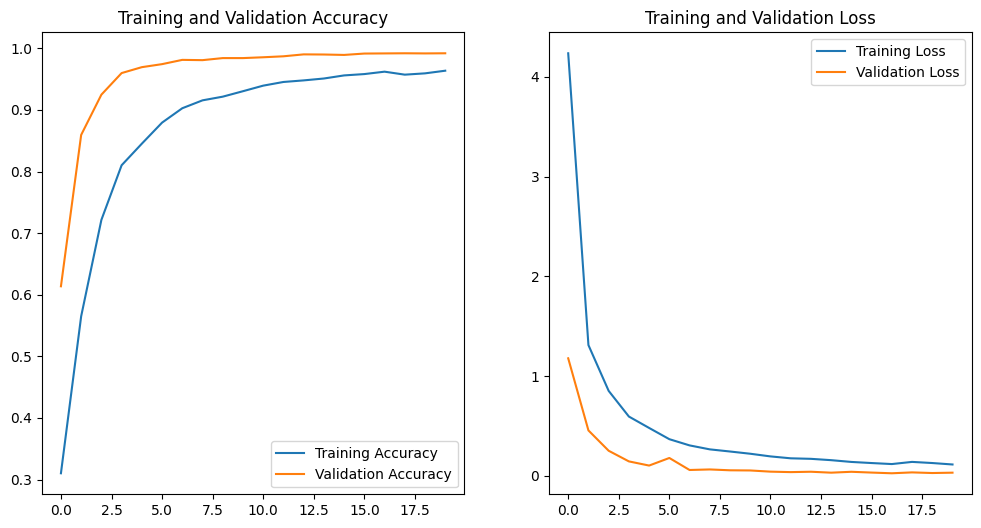

In [12]:
plot_training_history(history)

In [13]:

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy*100:.2f}%, Test loss: {test_loss:.2f}")


# Generate predictions for all images in the test set
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)



36/36 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.9937 - loss: 0.0386
Test accuracy: 99.29%, Test loss: 0.08
36/36 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step


              precision    recall  f1-score   support

          c0       0.11      0.11      0.11       497
          c1       0.11      0.11      0.11       453
          c2       0.10      0.10      0.10       463
          c3       0.09      0.09      0.09       469
          c4       0.09      0.09      0.09       465
          c5       0.10      0.10      0.10       462
          c6       0.09      0.09      0.09       465
          c7       0.09      0.09      0.09       400
          c8       0.08      0.08      0.08       382
          c9       0.12      0.12      0.12       425

    accuracy                           0.10      4481
   macro avg       0.10      0.10      0.10      4481
weighted avg       0.10      0.10      0.10      4481



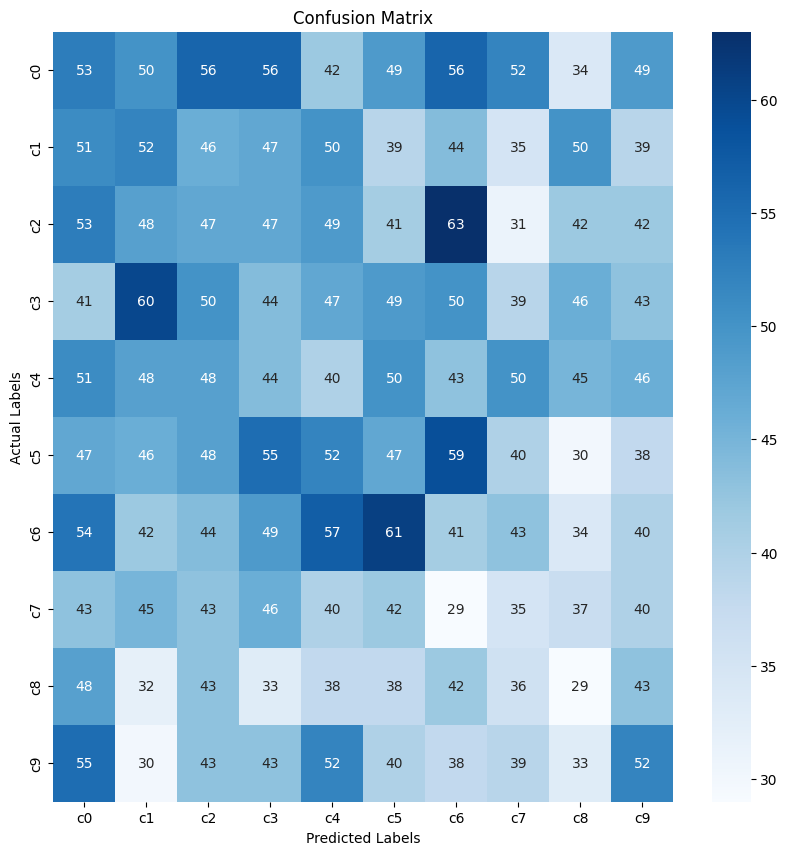

In [14]:
# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()